# 13.5 Training on Multiple GPUs

So far we discussed how to train models efficiently on CPUs and GPUs. We even showed how deep learning frameworks allow one to parallelize computation and communication automatically between them in Section 13.3. We also showed in Section 6.7 how to list all the available GPUs on a computer using the nvidia-smi command. What we did not discuss is how to actually parallelize deep learning training. Intead, we implied in passing that one would somehow split the data across multiple devices and make it work. The present section fills in the details and shows how to train a network in parallel when starting froms scratch.

## 13.5.1 Splitting the Problem

Let's start with a simple computer vision problem and a slightly archaic network, e.g., with multiple layers of convolutions, pooling, and possibly a few fully connected layers in the end. That is, let's start with a network that looks quite similar to LeNet or AlexNet. Given multiple GPUs, we want to partition training in a manner as to achieve good speedup while simultaneously benefitting from simple and reproducible design choices. Multiple GPUs, after all, increase both memory and computation ability. In a nutshell, we have the following choices, given a minibatch of training data that we want to classify.

First, we could partition the network across multiple GPUs, That is, each GPU takes as input the data flowing into a particular layer, processes data across a number of subsequent layers and then sends the data to the next GPU. This allows us to process data with larger entworks when compared with what a single GPU could handle. Besides, memory footprint per GPU can be well controlled.

However, the interface between layers (and thus GPUs) requires tight synchronization. This can be tricky, in partiular, if the computational workloads are not properly matched between layers. The problem is exacerbated for large numbers of GPUs. The interface between layers also requires large amounts of data transfer, such as activations and gradients. This may overwhelm the bandwidth of the GPU buses. moreover, compute-intensive, yet sequential operations are nontrivial to partition. It remains a difficult problem and it is unclear whether it is possible to achieve good (linear) scaling on nontrivial problems. 

Second, we could split the work layerwise. For instance, rather than computing 64 channnels on a single GPU we could split up the problem across 4 GPUs, each of which generates data for 16 channels. Likewise, for a fully connected layer we could split the number of output units. The following figure illustrates this design, where this strategy was used to deal with GPUs that had a very small memory footprint. This allows for good scaling in terms of computation, provided that the number of channels is not too small. Besides, multiple GPUs can process increasingly larger networks since the available memory scales linearly.

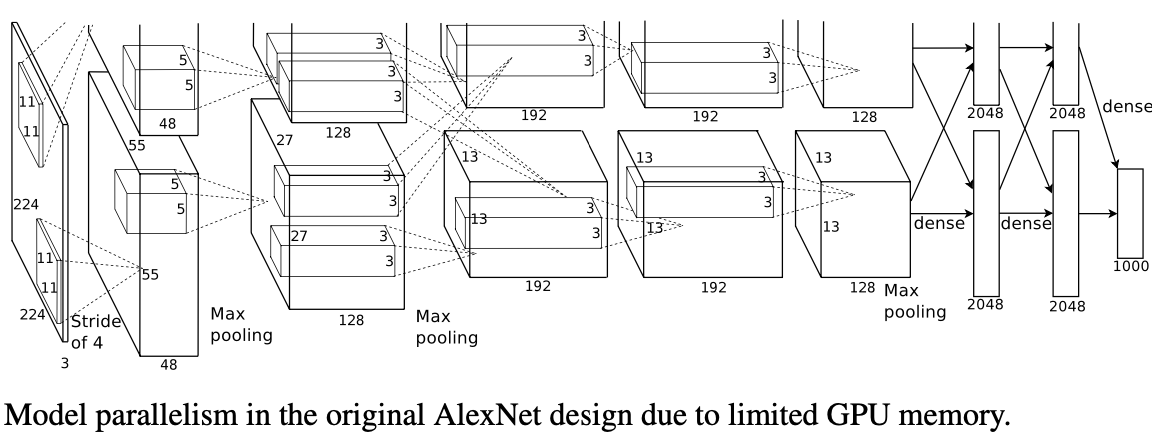

However, we need a very large number of synchronization or barrier operations since each layer depends on the results from all the other layers. Moreover, the amount of data that needs to be transferred is potentially even larger than when distributing layers across GPUs. Thus, we do not recommend this approach due to its bandwidth cost and complexity.

Last, we could partition data across multiple GPUs. This way all GPUs perform the same type of work, albeit on different observations. Gradients are aggregated across GPUs after each minibatch of training data. This is the simplest approach and it can be applied in any situation. We only need to synchronize after each minibatch. That said, it is highly desirable to start exchanging gradients parameters already while others are still being computed. Moreover, large numbers of GPUs lead to larger minibatch sizes, thus increasing training efficiency. However, adding more GPUs does not allow us to train larger models.

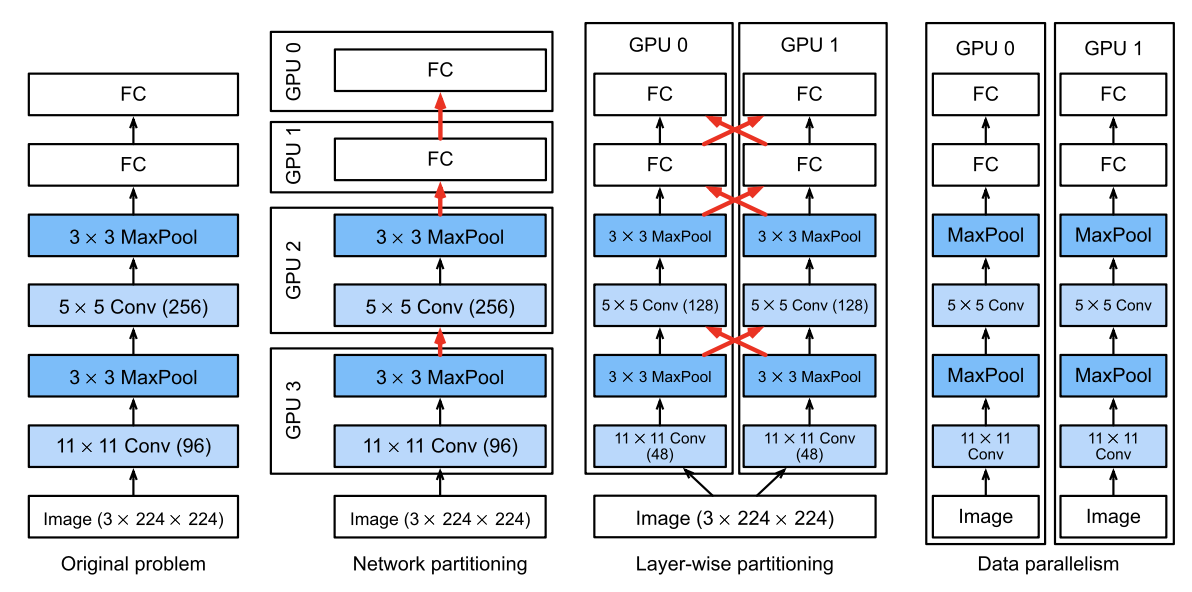

A comparison of different ways of parallelization on multiple GPUs is depicted in Fig. 13.5.2. By and large, data parallelism is the most convenient way to proceed, provided that we have access to GPUs with sufficiently large memory. See also (Li et al., 2014) for a detailed de- scription of partitioning for distributed training. GPU memory used to be a problem in the early days of deep learning. By now this issue has been resolved for all but the most unusual cases. We focus on data parallelism in what follows.

## 13.5.2 Data Parallelism

Assume that there are $k$ GPUs on a machine. Given the model to be trained, each GPU will maintain a complete set of model parameters independently though parameter values across the GPUs are identical and synchronized. As an example, Fig 13.5.3 illustrates training with data parallelism when $k = 2$.

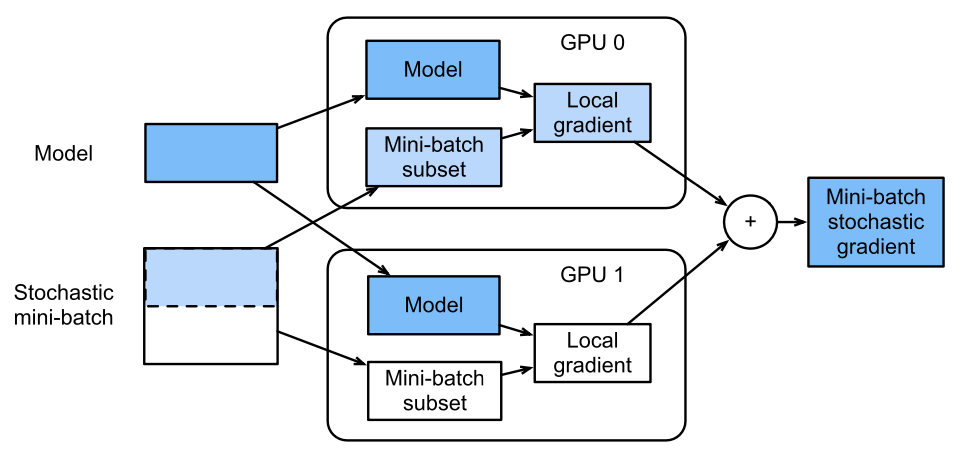

In general, the training proceeds as follows:

 - In any iteration of training, given a random minibatch, we split the examples in the batch into $k$ portions and distribute them evenly across the GPUs.

 - Each GPU calculates loss and gradients of the model parameters based on the minibatch subset it was assigned.

 - The local gradients of each of the $k$ GPUs are aggregated to obtain the current minibatch stochastic gradient.

 - The aggregate gradient is re-distributed to each GPU.

 - Each GPU uses this minibatch stochastic gradient to update the complete set of model parameters that it maintains.

 

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 13.5.3 A Toy Network

We use LeNet as introduced in Section 7.6. We define it from scratch to illustrate parameter exchange and synchronization in detail

In [2]:
# Initialize model parameters
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]
# Define the model
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat
# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')


## 13.5.4 Data Syncrhonization


For efficient multi-GPU training we need two basic operations. First we need to have the abil- ity to distribute a list of parameters to multiple devices and to attach gradients (get_params). Without parameters it is impossible to evaluate the network on a GPU. Second, we need the ability to sum parameters across multiple devices, i.e., we need an allreduce function.

In [4]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

Let’s try it out by copying the model parameters to one GPU.

In [5]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


Since we did not perform any computation yet, the gradient with regard to the bias param- eter is still zero. Now let’s assume that we have a vector distributed across multiple GPUs. The following allreduce function adds up all vectors and broadcasts the result back to all GPUs. Note that for this to work we need to copy the data to the device accumulating the results.

In [6]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

Let’s test this by creating vectors with different values on different devices and aggregate them.


In [7]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


## 13.5.5 Distributing Data

We need a simple utility function to distribute a minibatch evenly across multiple GPUs. For instance, on two GPUs we would like to have half of the data to be copied to either of the GPUs. Since it is more convenient and more concise, we use the built-in function from the deep learning frmaework to try it out on a $4 \times 5$ matrix

In [8]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


In [9]:
#@save
def split_batch(X, y, devices):
    """Split `X` and `y` into multiple devices."""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

## 13.5.6 Training

Now we can implement multi-GPU training on a single minibatch. Its implementation is primarily based on the data parallelism approach described in this section. We will use the auxiliary functions we just discussed, allreduce and split_and_load, to synchronize the data among multiple GPUs. Note that we do not need to write any specific code to achieve parallelism. Since the computational graph does not have any dependencies across devices within a minibatch, it is executed in parallel automatically.

In [10]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # Loss is calculated separately on each GPU
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # Backpropagation is performed separately on each GPU
        l.backward()
    # Sum all gradients from each GPU and broadcast them to all GPUs
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # The model parameters are updated separately on each GPU
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # Here, we use a full-size batch

In [11]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # Copy model parameters to `num_gpus` GPUs
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # Perform multi-GPU training for a single minibatch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # Evaluate the model on GPU 0
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

test acc: 0.84, 3.8 sec/epoch on [device(type='cuda', index=0)]


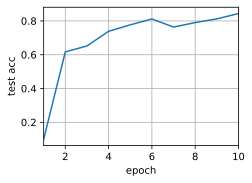

In [12]:
train(num_gpus=1, batch_size=256, lr=0.2)

test acc: 0.84, 8.6 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


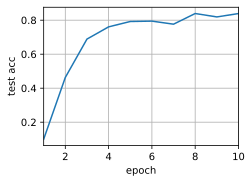

In [13]:
train(num_gpus=2, batch_size=256, lr=0.2)